# Background
Scientists define there to be two main types of age: chronological, and biological age. Chronological age is based on how long you have been alive (years since birth), whereas biological age is a rough estimate of how healthy your body is by measuring various different biomarkers. For more information on this, check out my recent article on biological age right here: [What is Biological Age?](https://medium.com/biotein/what-is-biological-age-383692f53e60)

One way of determining biological age (as also described in the article) is to measure the methylation levels in your genome. At sites known as CpG sites, along your DNA, various proteins can add on or remove methyl groups, in order to control which genes are expressed into proteins, and which ones aren't. As you age, however, the systems responsible for maintaining this control of the genome begin to break down, leading to errors in methylation. As such, some sites begin to see an accumulation of methyl tags, while others have their tags removed, as you age.

Dr. Steve Horvath, longevity researcher at University of California Los Angeles, used this progression to develop a system known as the Horvath aging clock, which is able to produce an accurate estimate of your biological age. For example, after analyzing the methylation levels in a sample of your cells, the clock might tell you that your biological age is around 30, which basically means that your methylation levels (and your body's health) is similar to the average 30-year-old. If your actual age is somewhere around 40, this means you are living a healthy life, whereas if you are only 20 years old, then this suggests that you are living an unhealthy life. This information thus equips people with the knowledge to take control of their lifestyle and live a healthy life.

# Brief Explanation of This Project
In this project, I aim to somewhat replicate the epigenetic clock developed by Horvath, using methylation data taken from blood samples to predict an individual's age. The datasets and methylation sites chosen for this project were advised by the research paper titled [Human Age Prediction Based on DNA Methylation Using a Gradient Boosting Regressor](https://doi.org/10.3390/genes9090424).
There are two notable differences between the paper and this code:
1. Since this code also takes into account the gender of the patients whose methylation data is available, GSE30870, which does not contain gender information in the dataset, was removed from the sample.
2. This notebook contains three different ML Regression algorithms and a Deep Neural Network, and compares the performance of each model on the training and testing dataset. The four models developed in this notebook are: Multivariable Linear Regression, Random Forest Regression, Gradient Boosting Regression, and a Deep Neural Network.

In [1]:
# Imports
import pandas as pd

from sklearn.utils import shuffle
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

import numpy as np

In [2]:
# Loading methylation dataset using Pandas
path = "C:/Users/aadid/Documents/Extra/R_Code/Epigenetic-Clock/Methylation_Dataset.csv"
df = pd.read_csv(path)
df.head()

,...1,cg09809672,cg22736354,cg02228185,cg01820374,cg06493994,cg19761273,gender,age
0,GSM507152,0.392464,0.281630,0.352591,0.315924,0.111604,0.211683,1,71.06
1,GSM507153,0.377919,0.238900,0.520396,0.323641,0.127965,0.184307,1,69.65
2,GSM507154,0.458522,0.204078,0.519273,0.363714,0.119891,0.215067,1,65.79
3,GSM507155,0.479108,0.154893,0.618859,0.493972,0.088941,0.240057,1,49.39
4,GSM507156,0.418763,0.217832,0.561005,0.398580,0.085992,0.207462,1,60.68


In [3]:
df.describe()

,cg09809672,cg22736354,cg02228185,cg01820374,cg06493994,cg19761273,gender,age
count,1433.000000,1433.000000,1432.000000,1433.000000,1433.000000,1433.000000,1440.000000,1342.000000
mean,0.643915,-0.034537,0.707461,0.469240,-0.126709,0.190323,0.398611,16.876972
std,0.182962,0.631238,0.181514,0.249634,0.818831,0.429598,0.489782,20.195080
min,-0.142805,-3.426375,0.249870,-0.652701,-3.671870,-1.865495,0.000000,0.000000
25%,0.508143,0.063395,0.634600,0.369900,0.038618,0.220460,0.000000,0.000000
50%,0.649500,0.093690,0.716848,0.500220,0.056750,0.295079,0.000000,9.250000
75%,0.819000,0.192362,0.791519,0.610516,0.112080,0.369000,1.000000,26.000000
max,0.981229,0.460100,1.836750,0.946000,0.308694,0.809860,1.000000,76.498290


Here we first shuffle our dataset to remove any confounding factors that may exist as a result of the ordering of the dataset, such as an inappropriate train-test split. We also reset the indices after the shuffling, and drop all rows with missing values (or NaNs).

In [4]:
# Shuffle dataframe to randomize data order, possibly preventing confounding factors
df = shuffle(df)
df.reset_index(inplace=True, drop=True)

# Remove patient ID column
df = df.drop(['...1'], axis=1)

# Drop all rows with NaN values
df = df.dropna()

df.head()

,cg09809672,cg22736354,cg02228185,cg01820374,cg06493994,cg19761273,gender,age
1,0.526730,0.110600,0.403080,0.444260,0.054940,0.147440,1,52.000000
2,0.697096,0.086370,0.742653,0.513994,0.058070,0.335168,1,0.000000
3,0.641280,0.075930,0.749420,0.538040,0.043000,0.307800,0,7.416667
4,0.549140,0.120250,0.725800,0.485050,0.053460,0.244870,0,17.000000
5,0.490546,0.118865,0.472128,0.466561,0.054391,0.234134,1,44.000000


In [5]:
# Checking if there are any remaining NaNs in the dataset
np.where(pd.isnull(df))

(array([], dtype=int64), array([], dtype=int64))

Below, we plot the correlation matrix, or heatmap, to compare the variables. As can be seen in the lowest row (labelled age),  the methylation sites that might be the best predictors of age (the most strongly correlated, whether negative or positive) are cg09809672, cg01820374, and cg19761273.
We also see that gender seems to have a positive positive correlation with age. This suggests a possible confounding factor that may arise as a result of the dataset, since it seems that the females in the dataset (labelled as 1) are older than the males (labelled 0).

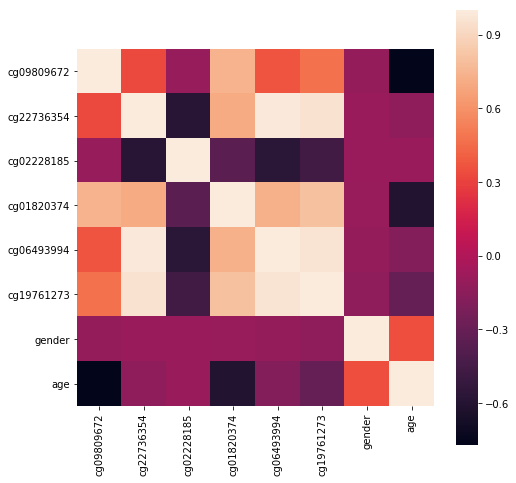

In [6]:
# Plot correlation matrix, or heatmap, to compare variables. As can 
# be seen in the lowest row (labelled age), the methylation sites
# that might act as the best predictors of age are cg09809672,
# cg01820374, and cg19761273.
import seaborn as sb
C_mat = df.corr()
fig = plt.figure(figsize = (8,8))

sb.heatmap(C_mat, vmax=1, square=True)
plt.show()

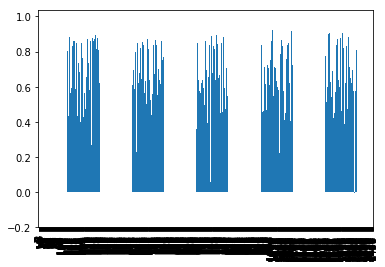

In [7]:
# Plotting the data for cg09809672 prior to normalization by the Standard Scaler model
df['cg09809672'].plot(kind='bar')

In [8]:
# Normalizing the methylation and gender data with a Standard Scaler.
X = df[['cg09809672', 'cg22736354', 'cg02228185', 'cg01820374', 'cg06493994', 'cg19761273', 'gender']]
std_scaler = StandardScaler()
std_scaler

# Separating X vs. y dataframes
X_std = pd.DataFrame(std_scaler.fit_transform(X), columns=X.columns)
y = df['age']

C:\Users\aadid\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\aadid\AppData\Roaming\Python\Python37\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


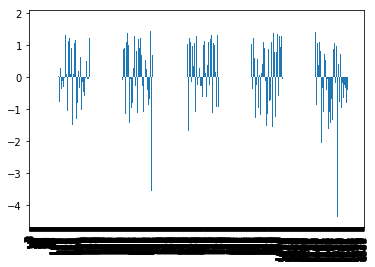

In [9]:
# Plotting the data for cg09809672 after normalization
X_std['cg09809672'].plot(kind='bar')

In [10]:
# Separating dataset into train and test subsets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42)

Based on the score and predictions printed below, we see that the linear regression model is only somewhate capable of accurately predicting the age of an individual using the methylation levels inputted, with roughly 75% testing accuracy (varies with each run).

In [11]:
# Training the multivariate linear regression model
linear_regressor = linear_model.LinearRegression()
linear_regressor.fit(X_train, y_train)

# Accuracy on the testing set
print(linear_regressor.score(X_test, y_test))

0.737530740738999


In [12]:
predictions = linear_regressor.predict(X_test)

# Since age cannot be negative, changing all negative predictions to age 0
for n, element in enumerate(predictions):
    if element < 0:
        predictions[n] = 0

# Looking at sample predictions for the testing set
for i in range(0, 10):
    print("Prediction:", predictions[i], "\tActual:", y_test.iloc[i])

Prediction: 14.615317246070568 	Actual: 17.0
Prediction: 9.901882142771562 	Actual: 7.25
Prediction: 53.169892214472505 	Actual: 65.53
Prediction: 9.193458789417647 	Actual: 0.0
Prediction: 15.57978693629444 	Actual: 9.083333332999999
Prediction: 8.643369736906834 	Actual: 4.583333333
Prediction: 9.575357543741958 	Actual: 5.833333333
Prediction: 0.0 	Actual: 0.0
Prediction: 6.336825213612727 	Actual: 7.75
Prediction: 18.66591306424644 	Actual: 16.08333333


Looking at the score for the model below, we can see that the Random Forest Regressor model is quite accurate at predicting an individual's age using their methylation data, with roughly 92% testing accuracy (varies with each run).

In [13]:
# Building and training the Random Forest Regressor model
from sklearn.ensemble import RandomForestRegressor

# Optimal value for n_estimators was determined by trial and error, comparing the score for each trial
random_forest_regressor = RandomForestRegressor(n_estimators = 17, random_state = 0)
random_forest_regressor.fit(X_train, y_train)

# Accuracy on the testing set
print(random_forest_regressor.score(X_test, y_test))

0.9119492435704226


In [14]:
predictions = random_forest_regressor.predict(X_test)

# Since age cannot be negative, changing all negative predictions to age 0
for n, element in enumerate(predictions):
    if element < 0:
        predictions[n] = 0

# Looking at sample predictions for the testing set
for i in range(0, 10):
  print("Prediction:", predictions[i],"\tActual:", y_test.iloc[i])

Prediction: 11.024509804058825 	Actual: 17.0
Prediction: 7.598039215882354 	Actual: 7.25
Prediction: 64.13999999999999 	Actual: 65.53
Prediction: 0.0 	Actual: 0.0
Prediction: 10.132352940764704 	Actual: 9.083333332999999
Prediction: 5.936274509823529 	Actual: 4.583333333
Prediction: 6.044117646941176 	Actual: 5.833333333
Prediction: 0.0 	Actual: 0.0
Prediction: 5.794117647176471 	Actual: 7.75
Prediction: 12.460784314823533 	Actual: 16.08333333


Looking at the two code blocks below, we see that the Gradient Boosting Regressor model, though not as accurate as the Random Forest Regressor, is still fairly accurate at generating the predictions using the data given, with roughly 86% accuracy on the testing set (varies with each run).

In [15]:
# Building and training the Gradient Boosting Regressor model
from sklearn.ensemble import GradientBoostingRegressor

# The values of n_estimators, max_depth, and learning_rate were determined by trial and error,
# to obtain the obtimal values shown below.
params = {'n_estimators':3, 'max_depth':3, 'learning_rate': 1, 'criterion': 'mse'}

gradient_boosting_regressor = GradientBoostingRegressor(**params)
gradient_boosting_regressor.fit(X_train, y_train)

print(gradient_boosting_regressor.score(X_test, y_test))

0.845543855616767


In [16]:
predictions = gradient_boosting_regressor.predict(X_test)
for i in range(0, 10):
    if predictions[i] < 0:
        predictions[i] = 0
    print("Prediction:", predictions[i],"\tActual:", y_test.iloc[i])

Prediction: 3.505938486564964 	Actual: 17.0
Prediction: 13.707487215165807 	Actual: 7.25
Prediction: 63.32399212235803 	Actual: 65.53
Prediction: 0.0 	Actual: 0.0
Prediction: 13.707487215165807 	Actual: 9.083333332999999
Prediction: 7.9033466716685465 	Actual: 4.583333333
Prediction: 7.9033466716685465 	Actual: 5.833333333
Prediction: 0.0 	Actual: 0.0
Prediction: 7.9033466716685465 	Actual: 7.75
Prediction: 15.655788267536703 	Actual: 16.08333333


In [17]:
import tensorflow as tf
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten

# Creating the sequential neural network model
NN_model = Sequential()

# Input layer
NN_model.add(Dense(128, kernel_initializer='normal', input_dim=X_train.shape[1], activation='relu'))

# Hidden layers
NN_model.add(Dense(256, kernel_initializer='normal', activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal', activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal', activation='relu'))

# Output layer
NN_model.add(Dense(1, kernel_initializer='normal', activation='linear'))


# Compile NN
NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error', 'accuracy'])
NN_model.summary()

Using TensorFlow backend.
W0107 15:07:13.949198 16976 deprecation.py:506] From C:\Users\aadid\AppData\Roaming\Python\Python37\site-packages\tensorflow_core\python\ops\resource_variable_ops.py:1633: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               1024      
_________________________________________________________________
dense_2 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_3 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_4 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 257       
Total params: 165,889
Trainable params: 165,889
Non-trainable params: 0
_________________________________________________________________


As seen in the plots showing the accuracy and loss as the model continues training, or the evaluation in the very last block, the neural network is extremely poor at predicting an individual's age, with an accuracy of around 30% (varies with each run).

In [18]:
history = NN_model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split = 0.2, verbose=0)

W0107 15:07:14.503745 16976 deprecation.py:323] From C:\Users\aadid\AppData\Roaming\Python\Python37\site-packages\keras\optimizers.py:550: BaseResourceVariable.constraint (from tensorflow.python.ops.resource_variable_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Apply a constraint manually following the optimizer update step.
W0107 15:07:14.869284 16976 module_wrapper.py:136] From C:\Users\aadid\AppData\Roaming\Python\Python37\site-packages\tensorflow_core\python\util\module_wrapper.py:163: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.



In [19]:
print(history.history.keys())

dict_keys(['val_loss', 'val_mean_absolute_error', 'val_accuracy', 'loss', 'mean_absolute_error', 'accuracy'])


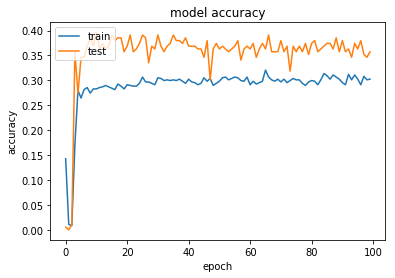

In [20]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

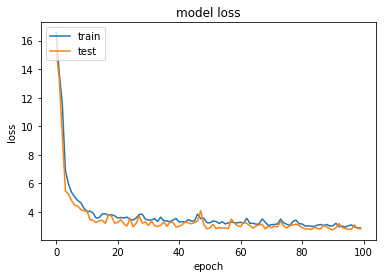

In [21]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [22]:
evaluation = NN_model.evaluate(X_test, y_test, batch_size=32)
loss = evaluation[0]
acc = evaluation[2]
print("Test loss:", loss)
print("Test accuracy:", acc)

441/441 [==============================] - 0s 48us/step
Test loss: 2.956726800557437
Test accuracy: 0.30612245202064514


# Conclusion
With the code seen above, we conclude that the Random Forest Regression model is the best model of the four, and is able to fairly accurately predict an individual's age using their methylation levels at the 6 sites. Not far behind in accuracy is the Gradient Boosting model. The Linear Regression model is not as accurately able to predict the age, but is still able to do so much much more accurately than the neural network, which was only able to achieve a testing accuracy of roughly 30%, and validation accuracy ranging from 30-35%.